# PHYS 2201
## Computational Assignment 2
## Stephen Catsamas (u7121433)


In [24]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random

We will investigate the numerical solutions to particles in a flow-field. Note that we have conducted this analysis without choosing a length or time scale for our system, and so all quantities are quoted dimentionlessly.

## Question 1

First we will construct an ODE solver to propagate particle trajectories in a flow field forward in time.<br>
We will then use the solver to demonstrate that particles in a two-vortex velocity field Eq. (1) follow regular orbits.


Specifically the flow field for the vortices located at $\mathbf{x} = (\beta,0)$ and $\mathbf{x} = (-\beta,0)$ is given by

\begin{align}
   \frac{\mathrm{d}x}{\mathrm{d} t} = u(x,y) &= \frac{- \alpha y}{(x-\beta)^2 + y^2} - \frac{\alpha y}{(x+\beta)^2 + y^2}  && (1a)\\
    \frac{\mathrm{d}y}{\mathrm{d} t} = v(x,y) &= \frac{\alpha(x-\beta)}{(x-\beta)^2 + y^2} + \frac{\alpha(x+\beta)}{(x+\beta)^2 + y^2} && (1b)
\end{align}
With $\alpha=1$ and $\beta=0.4$.
This equation can be solved using an ODE solver, by integrating numerically with respect to time.<br>
First we will define this flow field in a function we can call:

In [25]:
def get_flow(x, y):
    alpha = 1
    beta = 0.4

    u = - alpha*y/((x-beta)**2 + y**2) - alpha*y/((x+beta)**2 + y**2) 
    v = alpha*(x-beta)/((x-beta)**2 + y**2) + alpha*(x+beta)/((x+beta)**2 + y**2)
    
    return u,v

#### ODE Solver
We will use the primer to implement Runge–Kutta 4th order (RK4) method with adaptive step size as outlined in [[1]](https://doi.org/10.1063/1.4823060)

With adaptive step size we aim to estimate the error in our numerical solution and use this to adjust the step size the ODE solver to have a some control on the error of the solution whilst also not begin overly computationally intensive with a globally small step size.

The underlying algorithm is unchanged however the method for the choice of the step size, $h$, is that:

An estimate for the error can be obtains by first taking a step of size $h$, giving solution $\mathbf{z}_1$, and then taking two steps of size $\frac{h}{2}$, giving solution $\mathbf{z}_2$. The difference of these $\Delta_1 = \mathbf{z}_1 - \mathbf{z}_2$, gives some indication of the numerical error.
    Since for the RK4 algorithm the numerical error is of order $O(h^5)$, then if we have an error of $\Delta_1$ using step size $h_1$, but would like a error of $\Delta_0$ with step size $h_0$, then $|\frac{\Delta_1}{\Delta_0}| = \frac{(h_1)^5}{(h_0)^2}$, that is that we should use a step size $h_0 = h_1 |\frac{\Delta_1}{\Delta_0}|^\frac{1}{5}$. In practice, to account for additional complicating factors, it is common to use the formula [[1]](https://doi.org/10.1063/1.4823060): $$h_0 = \left\lbrace \begin{matrix} Sh_1 |\frac{\Delta_1}{\Delta_0}|^\frac{1}{5}, & \Delta_0 \geq \Delta_1 \\ Sh_1 |\frac{\Delta_1}{\Delta_0}|^\frac{1}{4}, & \Delta_0 < \Delta_1 \end{matrix} \right. $$
Where $S = 0.90$

In [26]:
#Function: rK4 
#Inputs: 
#    t0 - initial time 
#    y0 - initial position 
#    h  - step size 
#system - function which defines the system to solve, when given a time and position should return the x,y time derivatives
#Returns:
#   array of [x',y',t'], where x',y' are a step of the system at time t0 + h
def rK4(t0, y0, h, system):
    # Runge-Kutta 4th Order Function (primer)
    
    #coefficients calulated as per RK4 algorithm
    k1 = h*system(t0, y0)
    k2 = h*system(t0 + 0.5*h, y0 + 0.5*k1)
    k3 = h*system(t0 + 0.5*h, y0 + 0.5*k2)
    k4 = h*system(t0 + h, y0 + k3)
    
    #increment solution by change found
    y = y0 + (1/6)*(k1+2*k2+2*k3+k4);
    t = np.array([t0 + h])
    
    #return the new state vector of the system
    return np.concatenate((y, t))

In [27]:
#Function: stepper
#Integrates the ODE specificed by system and returns position vectors
#Inputs: 
#    z0 - initial state of system [[x0,y0,t0]]
#  stop - ammount of time to simulate the system for 
#system - function which defines the system to solve. Defined as in rk4 function
#     h - initial step size 
# h_adj - if True then stepper will adjust time step dynamically, else it will keep the timestep constant at h.
# bound - if larger than zero will print a warming if solution is further from origin than value  
#Returns:
#    array [[x_i,y_i,t_i]] of solution to system over time from t0 to t0+stop.
def stepper(z0, stop, system, h = 0.01, h_adj = True, bound = 0):
    do_dyn_step = h_adj
    ##set first entry of output array to initial conditions
    loc= z0
    
    t0 = z0[0,2]
    
    #define array to give maximum acceptible error
    error = np.array([[1E-9,1E-9]])
    
    #find abs max norm of vector for later comparison (\Delta_0)
    merror = np.max(np.abs(error))
    
    #set initial dynamic step size to initial step size
    hdyn = h
    
    #loc[-1][2] is the latest step time, we want to itterate untill we have gotten to this time
    while(stop+t0 - loc[-1][2] > 0):
    
        try:
            #enable or disable dynamic step size
            if(do_dyn_step):
                #we now need to loop over one step untill we find the appropriate step size
                #for our set error, for most steps this should only take one itteration
                #we define this flag which to loop until we have found the right step size
                retry_flag = True

                while(retry_flag):

                    #take one double step in the solution
                    loc1=rK4(loc[-1][2], loc[-1][0:2], 2*hdyn, system)

                    #take two steps in the solution
                    loc_hf=rK4(loc[-1][2], loc[-1][0:2], hdyn, system)
                    loc2=rK4(loc_hf[2], loc_hf[0:2], hdyn, system)

                    #note here that loc is an array which defines a state vector, loc[i][0:2] defines the x,y position
                    #and loc[i][2] is the time

                    #take the difference of the double step and 2 steps solution positions as an estimate for the error (\Delta_1)
                    delta = loc1[0:2] - loc2[0:2]

                    #find the abs max norm of the error
                    mdelta = np.max(np.abs(delta))

                    #this if-statement is the dynamic step size adjustment
                    if mdelta <= merror:
                        #if the error of the step is less than the threshold we can go to the next step with a larger step size
                        if (mdelta!=0):
                            hdyn = 0.9 * hdyn * math.pow(merror/mdelta, 0.2)
                        retry_flag = False
                    else:
                        #otherwise we have more error than our threshold, so we should choose a smaller step size and try again
                        hdyn = 0.9 * hdyn * math.pow(merror/mdelta, 0.25)
                        retry_flag = True
                    #after we have exited the loop we have a solutuion with our error threshold,

            else:
                    #if not using dynmic step size then we just need to
                    #take a step in the solution
                    loc2=rK4(loc[-1][2], loc[-1][0:2], hdyn, system)
        except ValueError:
            break
            
        #here we add a warning if the solution has a position outside of the given bounds,
        #this is useful when calulating lyapunov exponents
        if (bound > 0):
            if (np.linalg.norm(z) > bound):
                print('Out of bounds warning')
        
        #if the most recent step oversteps the endpoint, we will should not append this point
        #and set the step size to the distance to the endpoint 
        if (stop+t0 - loc2[2] < 0):
                hdyn = stop+t0 - loc[-1][2]
                do_dyn_step = False
                continue
                
        #another error that we should check for is if the step size is zero
        #this is generally caused by a floating point math error
        #it is hard to handle this error, so we will just exit and warn the user
        if (loc[-1][2] == loc2[2]):
            print('Loop error')
            break
        
        
        #Add last step to the output array
        loc=np.vstack((loc,loc2))
        
        
        
    #after we have simulate the desired for the desired time we will return the output array    
    return loc



In [28]:
#Function: two_vortex
#used as an implementatation of the system function for rK4, on the flow field of get_flow
#Inputs: 
#    t - time 
#  vec - initial position 
#Returns:
#    array of dxdt,dydt, the time derivatives of position and velocity evaluated at (vec,t)
def two_vortex(t,vec):
    
    #unpack location vector
    X,Y=vec

    #get flow velocities from the get_flow function
    dxdt,dydt=get_flow(X, Y)
    
    #return array of the derivatives
    return np.array([dxdt,dydt])

As a quick check of our ODE solver we will verify it against a ODE for which we know the numerical solution:
    $$\frac{\mathrm{d}x}{\mathrm{d} t} = x$$
    $$\frac{\mathrm{d}y}{\mathrm{d} t} = y$$
Which has the solution for initial positions $x = x_0$ and $y = y_0$
   $$x(t) = x_0\mathrm{e}^t$$
   $$y(t) = y_0\mathrm{e}^t$$
To do this we first set up a 'system' function for our stepper function:

In [29]:
#Function: test_system
#used as an implementatation of the system function for rK4, system is a simple test DE as above
#Inputs: 
#    t - time 
#  vec - initial position 
#Returns:
#    array of dxdt,dydt, the time derivatives of position and velocity evaluated at (vec,t)
def test_system(t,vec):
    
    #unpack location vector
    X,Y=vec

    #get flow velocities from the get_flow function
    dxdt = X
    dydt = Y
    
    #return array of the derivatives
    return np.array([dxdt,dydt])

Using our ODE solver to find a solution

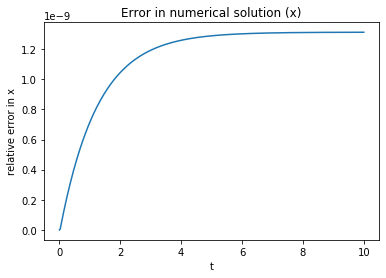

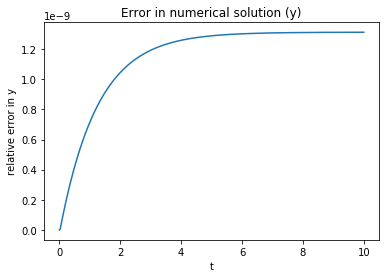

In [30]:
#define initial contitions
z0 = np.array([[1,1,0]])#x,y,t
#define initial step size
h  = 0.1

#solve the test ODE
loc = stepper(z0,10, test_system, h)

#calulate the relative error in the solution as the ration between the numeric and anylitic
x_rel_error = [1-abs(x/math.exp(t)) for x,y,t in loc]
y_rel_error = [1-abs(y/math.exp(t)) for x,y,t in loc]

#plot relative error
plt.title('Error in numerical solution (x)')
plt.ylabel('relative error in x')
plt.xlabel('t')
plt.plot(loc[:,2],x_rel_error)
plt.show()
plt.title('Error in numerical solution (y)')
plt.ylabel('relative error in y')
plt.xlabel('t')
plt.plot(loc[:,2],y_rel_error)

Note have set the absolute error target in each step to 1E-9. We can see that the ODE solver solves the system with very little error. This gives us some confidence that there are no major errors in it.

#### Two vortex system

For a more multivariable test we will test it against the dipole vortex system (1)<br>

We will test a series of initial conditions, to see the different dynamics of the system

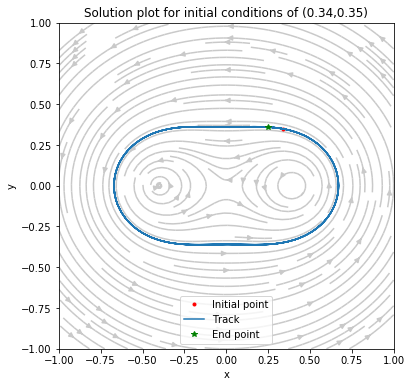

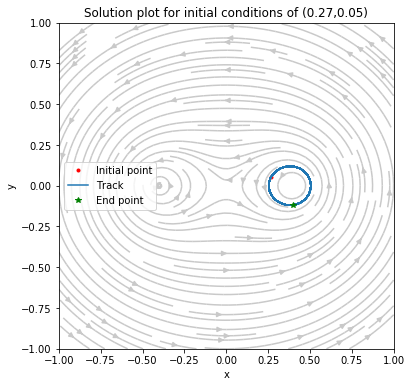

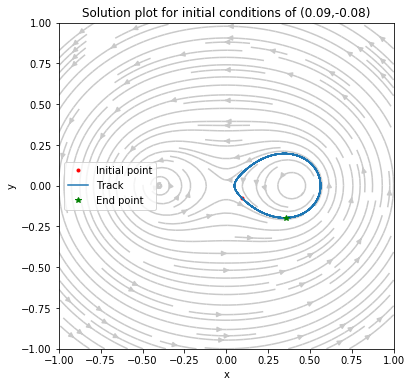

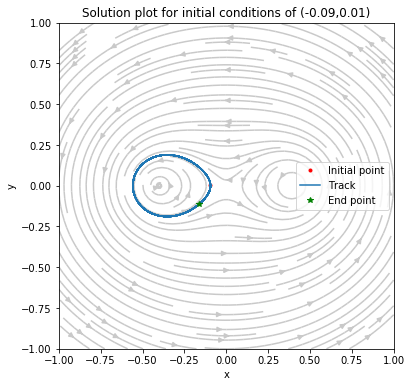

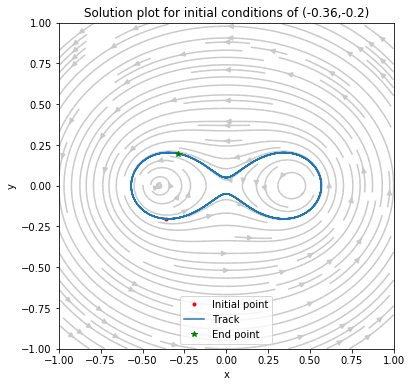

In [17]:
#Let us first create a plot of the flow field for a nice looking plot
y = np.linspace(-1,1,200)
x = np.linspace(-1,1,200)
X,Y = np.meshgrid(x,y)

u,v = get_flow(X,Y)

#quick function to plot the solutions of multiple initial conditions for the vortex system
def two_vortex_plot(x0,y0,t0,h = 0.01, h_dyn = True):

    #set initial conditions
    z0 = np.array([[x0,y0,t0]])#x,y,t

    #solve the two vortex system
    loc = stepper(z0,5, two_vortex, h, h_dyn)

    #plot the dipole system      
    plt.figure(figsize=(6,6))
    plt.streamplot(X,Y,u,v,density=1.5, color = '#c9c9c9')
    plt.title('Solution plot for initial conditions of (' + str(round(x0,2)) + ',' + str(round(y0,2)) + ')')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-1, 1])
    plt.xlim([-1, 1])
    plt.plot(loc[0,0],loc[0,1],'.r',label='Initial point')
    plt.plot(loc[:,0],loc[:,1],'-',label='Track')
    plt.plot(loc[-1,0],loc[-1,1],'*g',label='End point')
    plt.legend()
    
#use a loop to simulate a few random initial conditions:
for i in range(5):
    x0 = (random.random()-0.5)*1
    y0 = (random.random()-0.5)*.8
    two_vortex_plot(x0,y0,0,h)

Foremostly, we can see that in each of these simulations the particle follows regular orbits, that is that the particle returns to the same point in space (which is also our phase space since it defined the evolution of the system) after a finite amount of time. We can be see that the particles closely follow the flow lines, as expected. The system has at least two types of orbits, around one of the vortices, or around both of them. The ODE solver giving these results as expected gives us some more confidence that it is able to successfully integrate the system.

# Question 2

We will now demonstrate that our solver's numerical accuracy depends on the timestep of the system, we have assumed this in the creation of the dynamic time step adjustment of the system, however it will be good to verify. Specifically, we want to test that step size does affect the numerical accuracy of the system and that the error is of order $h^5$, an assumption in our dynamic step size algorithm.

For a qualitative estimate, we will simulate again our two vortex system however this time with a fixed time step and from the set position of (0.1,0.1). We will run this with time-steps of 5E-4, 5E-3, and 5E-2 and 5E-1 simulation time of 5. The point (0.1,0.1) is initially chosen as it represents a solution which has some distinct features, that is the 'peanut' shape path has high curvature which will likely not be resolved well by higher timesteps.

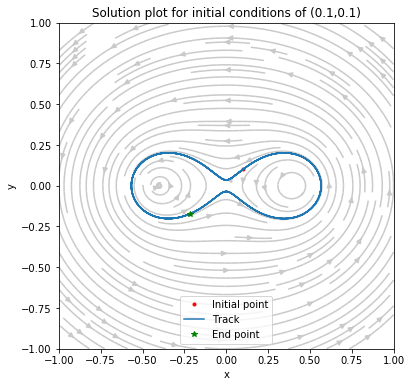

In [9]:
two_vortex_plot(.1,.1,0,5E-4, False)

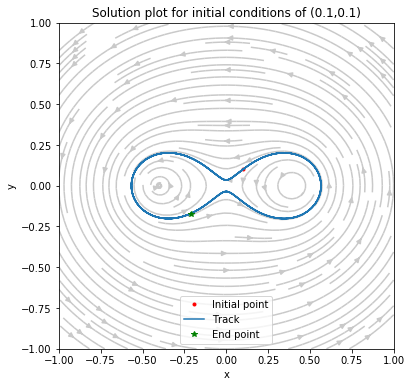

In [10]:
two_vortex_plot(.1,.1,0,5E-3, False)

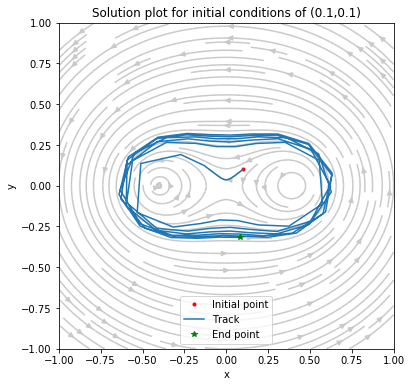

In [31]:
two_vortex_plot(.1,.1,0,5E-2, False)

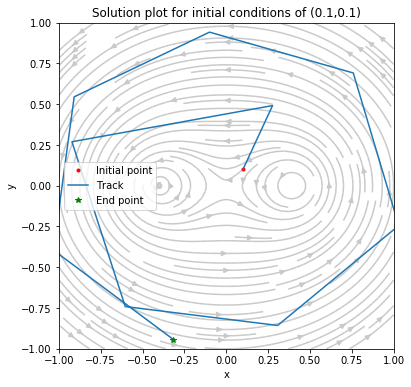

In [32]:
two_vortex_plot(.1,.1,0,5E-1, False)

We can see that the 5E-4 and 5E-3 timesteps both give solutions which are visually very good, they display the orbiting nature of the particle's solution with the system returning to the same point in phase space. Indeed it is seen that for a visually accurate plot for this system timestep 5E-4 is likely a waste of computation resources over a timestep of 5E-3. The timestep of 5E-2 however is very different to the other previous two timesteps. The solution is seen to be 'kicked out' of the orbit followed by the first two simulations within the first few timesteps, it appears to settle in a rough orbit further out around both vortices. The high timestep also introduces interpolation error, that is that the path is clearly seen to be a series of lines between points given by the solver, something less evident in the previous two simulations.
The final simulation of step size 5E-1 provides a much poorer accuracy. With few points simulated by the solver is hard to tell of the long term behaviour, however the points of the solution given are all much farther away from the vortices than the all the previous simulation.

In summary it is seen that the step size of the solution is important to achieving an accurate and usable solution, however past a certain point increasing step size is superfluous. 

We will now proceed to a quantitative estimate, to achieve this we will simulate our test system (the exponential ODE).
We will compare the error in the $x$ solution after one step of RK4 for different step sizes, where we know that for the initial conditions  of (1,1) and a step size h, we have that $x(h) = \mathrm{e}^h$.

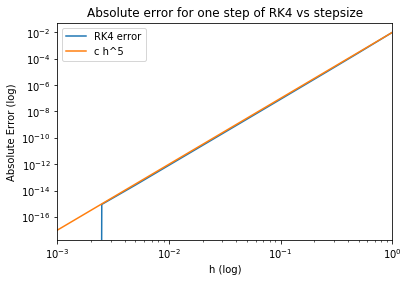

In [33]:
#create array of step sizes to test
h_sizes = [1, 5E-1, 2.5E-1, 1E-1, 5E-2, 2.5E-2,1E-2, 5E-3, 2.5E-3, 1E-3, 5E-4, 2.5E-4]
#create array to store output erros
error = []

for h in h_sizes:
    #take one step with RK4 from initial conditions of (1,1)
    x_val = rK4(0, [1,1], h, test_system)[0]
    
    #find the error as difference to RK4 solution and analytic solution
    error.append(abs(x_val-math.exp(h)))

#plot
plt.yscale('log')
plt.xscale('log')
plt.plot(h_sizes,error,label='RK4 error')
plt.plot([h_sizes[0],h_sizes[0]*1E-3],[error[0], error[0]*1E-15],label='c h^5')
plt.title('Absolute error for one step of RK4 vs stepsize')
plt.xlim([1E-3,1])
plt.xlabel('h (log)')
plt.ylabel('Absolute Error (log)')
plt.legend()

Note that the $ch^5$ has c chosen to fit the error found for $h = 1$. The plot clearly shows that the error in the RK4 solver for this system is of the order $h^5$, congruent with the assumptions made for our dynamic step size adjustment. The sudden drop of the error is due the precision of floating points that is that, since both the analytic and numeric solutions are close to 1 taking their difference results in a number with many fewer significant figures, specifically one the difference is smaller than about 1E-15, this is smaller than the precision at which python stores floating point these floating point values, hence their difference is computed as zero.

Whilst this error has only been quantified for the one system, it is assumed that the results will apply generally to all systems, that is that the error in the RK4 solver is proportional to the fifth power of the step size.

# Question 3

We will now run simulation on a blinking vortex system, this is a flow field with once vortices at $(\beta_0, 0)$ and $(-\beta_0, 0)$ which alternately are active [2]. 

The flow field is specifically defined by:

\begin{align}
    u(x,y,t) &= \frac{- \alpha y}{(x-\beta)^2 + y^2}   && (3a)\\
    v(x,y,t) &= \frac{\alpha(x-\beta)}{(x-\beta)^2 + y^2} && (3b)\\
    \beta(t) &=  \beta_0 \mathrm{sign}(\sin(2\pi t))  && (3c)\\
\end{align}
With $\alpha=1$ and $\beta=0.4$.

We are interested to investigate the chaotic  behaviour of this system.
To begin to analyse this system, let's is first create a 'system' function which we can use with our ODE solver.

In [34]:
b_alpha = 1
b_beta = 0.4
#Function: blink
#used as an implementatation of the system function for rK4, system is the blinking vorticies
#Inputs: 
#    t - time 
#  vec - initial position 
#Returns:
#    array of dxdt,dydt, the time derivatives of position and velocity evaluated at (vec,t)
def blink(t,vec):
    
    alpha = b_alpha
    beta = b_beta
    
    #unpack location vector
    X,Y=vec
  
    #find which vortex is active at the current time
    beta_t = beta*math.copysign(1,math.sin(2*math.pi*t))


    #get flow velocities from the get_flow function
    dxdt = - alpha*Y/((X-beta_t)**2 + Y**2)
    dydt =  alpha*(X-beta_t)/((X-beta_t)**2 + Y**2)
    
    #return array of the derivatives
    return np.array([dxdt,dydt])

We note that this will work fine to solve the motion of the system however we can see a much faster method.
First note that we have that the flow speed is dependant only on the distance from the active vortex, that is that
$$\mathbf{u}\cdot\mathbf{u} = u^2 + v^2 = \left(\frac{- \alpha y}{(x-\beta)^2 + y^2} \right)^2 + \left(\frac{\alpha(x-\beta)}{(x-\beta)^2 + y^2} \right)^2 = \frac{\alpha^2}{((x-\beta)^2 + y^2)^2}$$
This motivates us to consider the polar coordinate system $x-\beta = r \cos \theta, y = r \sin \theta$, so
$$|\mathbf{u}|  = \frac{\alpha}{(r \cos \theta)^2 + (r \sin \theta)^2} = \frac{\alpha}{r}$$
And 
\begin{align}
    u(r,\theta,t) &= \frac{- \alpha \sin \theta}{r}   \\
    v(r,\theta,t) &= \frac{\alpha \cos \theta}{r} \\
\end{align}
Taking the dot product between the position and velocity vectors we find that 
$$\mathbf{u}\cdot \mathbf{r} = (\frac{- \alpha \sin \theta}{r} r\cos \theta)  + (\frac{\alpha \cos \theta}{r} r\sin\theta) = 0$$
That is that the velocity has no component in the $r$ direction. Examining our equations we can see that the velocity is constantly $\frac{\alpha}{r}$ in the $\theta$ direction. Therefore we have that its angular velocity is $\omega = \frac{\alpha}{r^2}$, and so the angle it subtends in a given time $\Delta t$ is $\Delta \theta = \omega t = \frac{\Delta t \alpha}{r^2}$.

We can express this in cartesian coordinates again, the position after a time $\Delta t$, $(x,y)$ is related to the initial position $(x_0,y_0)$ by the transformation
$$\begin{bmatrix} x\\ y \end{bmatrix} = \left( \begin{bmatrix} \cos \frac{\Delta t \alpha}{r^2} & -\sin \frac{\Delta t \alpha}{r^2} \\ \sin \frac{\Delta t \alpha}{r^2} & \cos \frac{\Delta t \alpha}{r^2} \end{bmatrix}\begin{bmatrix} x_0 - \beta \\ y_0 \end{bmatrix} \right) + \begin{bmatrix}  \beta \\ 0 \end{bmatrix}$$
This is of course only valid so long as $\beta$ is constant. This is not true in our system as $\beta(t) = \beta_0 \mathrm{sign}\sin(2\pi t)$. However $\beta$ is constant over the 0.5 time units intervals where $\mathrm{sign}\sin(2\pi t)$ has the same sign. Therefore, if the time we want to solve over includes a change of $\beta$ we can simply solve until that change then switch then update the value of $\beta$ and continue solving. 

This method should be much faster and more accurate than solving the ODE with RK4. It should be faster as we only need to take one 'step' for each 0.5 time unit interval as opposed to the many more needed with the small step size of the RK4 solver. It should also be more accurate as we are not approximating the solution but calculating it exactly, the numerical errors should only be introduced in the at the end of each arc where the value of $\beta$ is to be switched.

Below we will implement this method

In [35]:
#Function: piecewise
#solves the blinking vorticy solver with the piecewise method described above
#Inputs: 
#    z0 - initial state of system [[x0,y0,t0]]
#  stop - ammount of time to simulate the system for
# bound - if larger than zero will print a warming if solution is further from origin than value
#Returns:
#    array [[x_i,y_i,t_i]] of solution to system over time from t0 to t0+stop.
#Notes:
#    This function returns an array with many fewer intermediate points than the stepper function.  
def piecewise(z0, stop, bound = 0):
    
    alpha = b_alpha
    beta = b_beta
    
    #clean input by converting to np array
    loc = np.array(z0)
    
    #seperate out position and time coordinates
    z = loc[:,0:2]
    t0 = loc[0,2]
    
    #set initial time to start of most recent vorticy switch
    time = math.floor(2*t0)/2
    
    #continue to itterate untill final position has been reached.
    while (stop+t0 > time):   
        
        #here we decide what if we need to solve for a full or partial vortex blink
        if (t0 > time):
            #the last vortex blink was before the start time we need to solve for t0 to the next vortex change or exit
            #this can only happen on loop entry
            if ((stop + t0) < time+0.5):
                #case for simulating less than one blink
                dt = stop
                time = t0
            else:
                #case for simulating more than one blink
                dt = 0.5 - (t0 - time)
                time = t0
        elif (stop+t0-time > 0.5):
            #if time is at the change of a vortex blink and we need to solve for the full blink:
            dt = 0.5
        else:
            #if we start at the change of a blink vortex but we only want to interare for some of it:
            dt = stop+t0-time
        
        #find the value of beta at a given time
        #using the floor function was found to give reliable results when evaluated at integer or half integer times
        #as opposed to sign(sin(2pi t)), which some times would not give opposing signs when evaluated at t and t+0.5.
        beta_t = beta*(1-2*(math.floor(2*time)%2))
        
        #increament the solvers internal time by the amount we have itterated by 
        time += dt
        
        #math help: square of the radial distance from votrex
        sqr = (z[0,0]-beta_t)**2 + (z[0,1])**2
        
        #angular velocity of fuild parcel
        omega = alpha/sqr
        #angle fluid parcel changes by over timestep
        theta = omega*dt
        
        #the new position of the fluid parcel is a rotation about the vortex by angle theta
        z = np.matmul(z-[[beta_t,0]],[[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]]) +[[beta_t,0]]
        
        #here we add a warning if the solution has a position outside of the given bounds,
        #this is sometimes useful when calulating lyapunov exponents
        if (bound > 0):
            if (np.linalg.norm(z) > bound):
                print('Out of bounds warning')
        
        #add itteration position to return list
        loc=np.vstack((loc,np.hstack((z,[[time]]))))
        
    return loc

As a check for the accuracy of the piecewise solver we can compare it against the stepper solver. This won't tell us if our new solver has no errors, however it will give us some confidence that the solutions given by the two solvers are mostly similar. 

To do this we will solve the system for a random set of initial conditions and a random length of time. We will then find the norm of the difference between the two solutions, and repeat this for a suitable number of points.

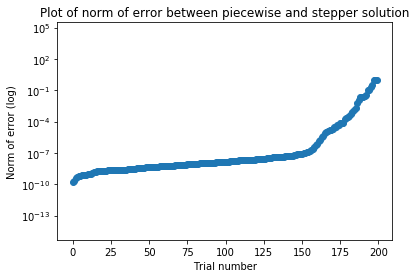

In [21]:
#define list to store the norm of the errors between the solvers
norms = []

#solve the system for a number of random points in the square of side length 1 centered at origin
for i in range(200):
    #get a random initial coordiant
    x0 = 2*(random.random()-0.5)
    y0 = 2*(random.random()-0.5)
    t0 = random.uniform(0, 10)
    T =  random.uniform(0, 10) #time to itterate for
    
    #create position array to give to solvers
    z0 = np.array([[x0,y0,t0]])
    
    #solve system using stepper and piecewise
    zRK4 = stepper(z0,T, blink, 0.01)[-1,0:2]
    zpiece = piecewise(z0, T)[-1,0:2]

    #record the norm of the difference vector
    norms.append(np.linalg.norm(zpiece-zRK4))
    
#plot all the norms 
norms.sort()
#sort the list because I think it is easier to see the distrobution of errors this way
plt.title('Plot of norm of error between piecewise and stepper solution')
plt.xlabel('Trial number')
plt.ylabel('Norm of error (log)')
plt.yscale('log')
plt.scatter(range(len(norms)),norms)

From this graph we see that the two solvers generally agree on their output to within a very small margin of error. For the majority of points to within 1E-7. It should be noted that the per-step accuracy of the stepper solver is set to 1E-9. Thus this likely indicates the floor to which the two solvers could agree.
About a quarter of points have a much larger error, with the highest being on the order of 1, the scale of the system.
This is somewhat to be expected if the system exhibits chaos, as it would imply that small differences due to errors in the solvers would tend to get enlarged.  
Overall the results indicate that the solutions given by the solvers should at most times be similar.

We will now create a small wrapper function to let us switch between the solvers:

In [36]:
#Function: solve_blink
#wrapper function to choose solver of blinking vortex system
#Inputs: 
#    z0 - initial state of system [[x0,y0,t0]]
#  stop - ammount of time to simulate the system for 
#     h - initial step size (RK4 only)
# h_adj - if True then stepper will adjust time step dynamically, else it will keep the timestep constant at h (RK4 only)
# bound - if larger than zero will print a warming if solution is further from origin than value 
#solver - choose solving algorithm 'pw' for piecewise, 'RK4' for RK4
#Returns:
#    array [[x_i,y_i,t_i]] of solution to system over time from t0 to t0+stop.  
def solve_blink(z0, stop, h = 0.01, h_adj = True, bound = 0, solver = 'RK4'):
    #clean input by converting to np array
    z0 = np.array(z0)
    if (solver == 'RK4'):
        sol = stepper(z0,stop, blink, h, h_adj, bound)
    elif (solver == 'pw'):
        sol = piecewise(z0, stop, bound = 0)
    else:
        raise ValueError('invalid keyword argument')
    return sol

To help out understanding of the system is it also a good idea to visualise the behaviour of the it. To do this we will write a function which will plot the system. Here we will use the RK4 solver as the piecewise solver only returns the position of the fluid parcel at the times when the vortices change, thus not returning enough points to make a good plot

In [37]:
#Function: blink_plot
#plots blinking vortex system 
#Inputs: 
#    z0 - initial state of system [[x0,y0,t0]]
#  stop - ammount of time to simulate the system for 
#     h - initial step size (RK4 only)
# h_adj - if True then stepper will adjust time step dynamically, else it will keep the timestep constant at h (RK4 only)
#Returns:
#    array [[x_i,y_i,t_i]] of solution to system over time from t0 to t0+stop. 
def blink_plot(z0,stop,h = 0.01, h_adj = True):
        
    #set initial conditions
    z = np.array(z0)#x,y,t

    #solve the dipole system with RK4
    loc = solve_blink(z,stop, h, h_adj, solver = 'RK4')
        
    #plot the dipole system      
    plt.figure(figsize=(6,6))
    plt.scatter([b_beta,-b_beta],[0,0], color = 'black', marker = '1')
    plt.title('Solution plot for initial conditions of (' + str(round(z[0,0],2)) + ',' + str(round(z[0,1],2)) + ')')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.plot(loc[:,0],loc[:,1],'-',label='Track')
    plt.plot(loc[0,0],loc[0,1],'.r',label='Initial point')
    plt.plot(loc[-1,0],loc[-1,1],'*g',label='End point')
    plt.legend(loc = 'upper left')
    
    return loc

Simulating a few random initial conditions:

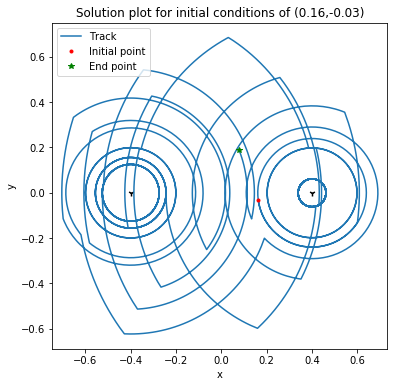

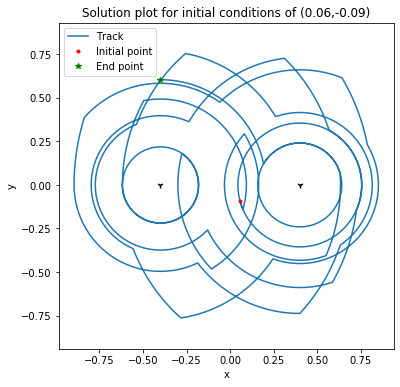

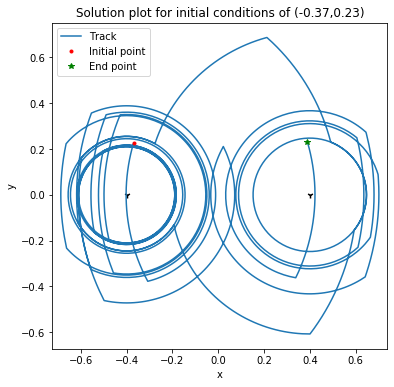

In [145]:
for i in range(3):
    x0 = (random.random()-0.5)*1
    y0 = (random.random()-0.5)*.8
    blink_plot([[x0,y0,0]],15)

From this we see that the behaviour of the system is complex. The behaviour is observed to be not obviously period, unlike the two-vortex system was. We also see that a simulation time of 15 is safely sufficient to allow the complex behaviour of the system to emerge, and an indication that this is long enough for chaotic behaviour to emerge as well.
Additionally, it is seen that the fluid tends to stay fairly close to the two vortices, that is stays within a finite volume of phase space, another good indication that our system may exhibit chaos.

It is interesting to see what happens when we solve for a solution outside of the region the above solutions lied. That is a solution farther than about 1 from the origin. 

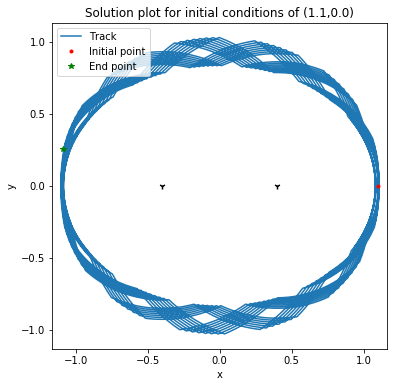

In [146]:
blink_plot([[1.1,0,0]],100);

We see that this solution does not exhibit the same complex behaviour as the solutions for closer to the origin. In fact, the solution looks much closer to being a period orbit of the two vortices. This makes intuitive sense, further away from the origin the two vortices become better approximated by a single vortex. Some precession of the solution appears to emerge with paths on consecutive orbits appearing to have some fairly consistent displacement from the previous orbit. 

We will now estimate a finite time Lyapunov exponent at a point of the system. The Lyapunov exponent is a quantification of the chaotic behaviour of a system.
Specifically if the Lyapunov is positive and the system is bounded by a finite region of phase space then the system is said to exhibit chaos.
The Lyapunov exponent at a point $z$ in phase space, is formally defined for a system that evolved in time:
$$\lambda = \lim_{t \rightarrow \infty} \lim_{d_0 \rightarrow 0} \frac{1}{t} \ln (\frac{d(t)}{d_0}) $$
Here $d_0$ is the initial distance between the solution beginning at $z$ and a displaced solution, $d(t)$ is their distance at a time $t$.
This is numerically difficult to compute hence the finite time Lyapunov exponent is defined via $\lambda = \overline{\lambda_i}$, where 
$$\lambda_i = \frac{1}{\Delta t} \ln (\frac{d(t_0 + i\Delta t)}{d_0})$$
Where $t_0$ is the initial time in the system, $\Delta t$ is a time interval the system  is evolved over.
Additionally after ever evolution for $\Delta t$, the displaced solution is scaled so it is again a distance $d_0$ from the $z$ solution.

To implement an algorithm to calculate a finite time Lyapunov exponent for our system we first need to find a suitable phase space for our system. It is noted that the evolution of a fluid parcel in the system is completely described by $x,y,t$ since the equations of motion (3) are only functions of these variables. Hence these variables are a basis for the phase space of the system. It should be noted that for the purposes of calculating Lyapunov exponents time is not interesting. This is because since we are evolving the system with time the solutions cannot have their time coordinate diverge and behave chaotically, in fact since the solutions are always evaluated at the same time, the distance in time between the $z$ solution and the displaced solution will always be zero, hence can be ignored. That is that for calculating Lyapunov exponents it is sufficient to consider $x,y$ a basis for the phase space.

As we are interested in the Lyapunov exponent to characterise the behaviour of the chaotic nature of the system it will be useful to also check that our solution stays within a finite region of phase space. To do this we will simply add a warning if when calculating the Lyapunov exponent the solution ever goes beyond a set distance from the origin. 
We will now implement the algorithm discussed in a function to estimate the finite time Lyapunov exponent from a point in the system.


In [38]:
#Function: est_lyap
#estimates the finite time lyapunov exponent from a point
#Inputs: 
#    z0 - initial state of system [[x0,y0,t0]]
#     N - number of lyapunov expoents to average over
#    Dt - ammount of time to system before renormalising 
#    d0 - initial displaced solution offset distance
#solver - if True then stepper will adjust time step dynamically, else it will keep the timestep constant at h (RK4 only)
# debug - if True function will plot debug information about calulation
# bound - if larger than zero will print a warning if solution is further from origin than value 
#Returns:
#    calulated finite time lyapunov exponent
def est_lyap(z0, N, Dt = 10, d0 = 1E-10, solver = 'pw', debug = False, bound = 0):
    #clean input
    z = np.array(z0,dtype=float)
    
    #we will crease an array to store the displaced solution
    zd = z.copy()

    #set the initial dispaced solution to an offset of d0 in the x direction
    #initial displacement direction does not matter as it should converge to the maximal direction
    zd[0,0] = zd[0,0] + d0

    #create arrays/lists to store outputs
    lyapexps = [] #lyapunov expoents
    zs = z        #solution coordintes
    zds = zd      #displaced solution coordiantes
    zns = []      #difference of solutions norms
    #itterate for given number of trials 
    for i in range(N):
        #evolve solution and dispclaced solution and store as coordiantes for next itteration
        z = solve_blink(z,Dt, solver = solver, bound = bound)[-1:]
        zd = solve_blink(zd,Dt, solver = solver,bound = bound)[-1:]
        
        #find the norm of the difference between the evolved solutions
        zd_norm = np.linalg.norm(zd[0,0:2]-z[0,0:2])
        #calulate the lyapunov exponent for this itteration
        lyapexp = 1/(Dt) * math.log(zd_norm/d0)
        
        #store calulated data in arrays
        lyapexps.append(lyapexp)
        zs=np.vstack((zs,z))
        zds=np.vstack((zds,zd))
        zns.append(zd_norm)
        
        #renormalise the dispalced solution to be distance d0 away
        zd[0,0] = z[0,0] + (zd[0,0]-z[0,0])*d0/zd_norm
        zd[0,1] = z[0,1] + (zd[0,1]-z[0,1])*d0/zd_norm
    
    if (debug):
        #plot additional information
        plt.title('Plot of lyapunov exponent vs itteration')
        plt.xlabel('Itteration number')
        plt.ylabel('Lyapunov exponent')
        plt.scatter(range(len(lyapexps)),lyapexps, s = 4)
        plt.show()
        plt.title('Plot of norm of final distance between solutions')
        plt.xlabel('Itteration number')
        plt.ylabel('Norm')
        plt.scatter(range(len(zns)),zns, s = 4)
        plt.show()
        plt.title('Plot of solutions')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis('equal')
        plt.scatter(zds[:,0],zds[:,1], color = 'C1',  s = 4, label = 'dispalaced solution')
        plt.scatter(zs[:,0],zs[:,1], color = 'C0',s = 4, label = 'solution')
        plt.legend(loc = 'upper left')
        plt.show()
        #print the average lyapunov exponent
        print(np.average(lyapexps))
        
    #return the average lyapunov exponent 
    return np.average(lyapexps)

Using our function to calculate a finite time Lyapunov exponent is non-trivial. There are a number of factors which may affect the accuracy and validity of our result.

The number of iterations to average over is a clear parameter which needs to be set. Ideally this should be as large as possible as this limit better approximates the non-finite time Lyapunov exponent. This is computationally infeasible. 400 iteration were chosen as here it was seen that the calculated Lyapunov exponent began to settled down on a particular value, while not taking an excessive amount of time to compute.

The time to iterate for $\Delta t$, and the initial distance $d_0$ are to parameters which needed to be chosen with consideration for each other. Again the limit $d_0 \rightarrow 0$, and $\Delta t \rightarrow \infty$ would be ideal however the finite machine precision means that $d_0 \rightarrow 0$ is not possible. For values on the order of 1 the minimum representable difference between two numbers Python can manage is about 1E-16. However before we can reach this limit we note that our dynamic step solver has a per step error on the order of 1E-9. Decreasing this per step error, would need more computation time, something which need to be managed between other parameters of the calculation. Therefore $d_0$ should be larger than 1E-9 to ensure that this error does not initially dominate the behaviour of the system. A value of 5E-9 was chosen because of this.
$\Delta t$ cannot be chosen to be arbitrarily large as eventually the divergence of the of the two solution will be on the order of the system. As the phase space is bounded this will result in the two solutions being unable to continue their exponential divergence, hence the Lyapunov exponent will be underestimated. $\Delta t$ of 6 was chosen as this was found to be the largest possible value after which the final displacement of the solutions $d(i \Delta t)$, was still much smaller than the size of the system. 

For the remainder of the parameters we choose to take estimate the Lyapunov exponent at (0,0), and we want to use the RK4 solver. We set a bounds warning of a 1.5 distance away from the origin to check that the solutions stay in a finite volume of phase space.


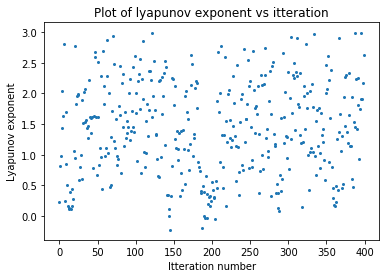

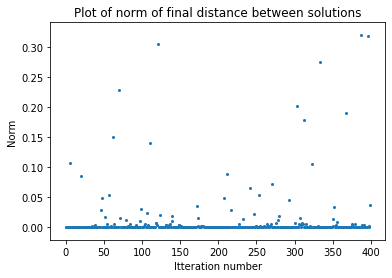

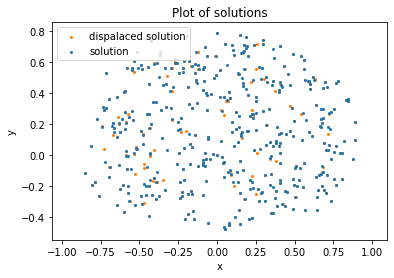

1.4243784500300356


In [205]:
est_lyap([[0,0,0]],400 ,Dt = 6,d0 = 5E-9 , solver = 'RK4', debug = True, bound = 1.5);

Running this algorithm we find that we have an estimated finite time Lyapunov exponent of 1.4, a positive value. The uncertainty in this figure is hard to quantify with the current data, however it was seen in the adjustment of the calculation parameters that this figure was commonly in within $\pm 0.3$ of $1.4$, hence it reasonable to use this as the uncertainty.
As we did not receive an out of bounds warning then we have also that the system evolves in a finite volume of phase space. Therefore this provides evidence that the system exhibits chaotic behaviour.

From the debug plots we can check other key indicators that we can have confidence in the found Lyapunov exponent. The first plot can be used mostly as a check to see if a major outlier or series of outliers exist in the data, however there appears to be nothing questionable about the magnitude or series of the $\lambda_i$ values. The second plot is more useful. This tell us that the maximum deviation between a solution and its displaced solution is about 0.33 with most being much smaller, on the order or less than 1E-2. This is safely less than the size of the solution and gives indicates that we have not chosen $\Delta t$ to be too large for the given value of $d_0$. The final plot again shows that the deviation between the solutions and displaced solution is small, albeit it does this less clearly. It confirms that the system is evolving in a finite region of phase space, which it appearing that all points lie within a roughly elliptical perimeter.
These graphs allows us to say with more certainty that our calculation of the finite time Lyapunov exponent is accurate. 


The calculated Lyapunov exponent of $ \lambda = 1.4 \pm 0.3$ is positive and the bounded behaviour of the system evolving in a finite region of phase space allows us to conclude that the blinking vortex system does exhibit chaos.


It is also interesting to map out the estimation of the Lyapunov exponent from different point in the system, to see if the chaotic behaviour is homogenous or if it has bounds. As discussed it is suspected that the behaviour far from the system will not be periodic, due to the system being better approximated by a single vortex. 

To accomplish this we can simply run our function for the Lyapunov exponent estimation on a grid of points. Here we will switch to the piecewise solver as it is many times faster than the RK4 solver. We have also reduced the number of iteration to 200 to reduce the computation time and adjusted $\Delta t = 5$ and $d_0 = 1E-11$.
This was done as the smaller value of $d_0$ and $\Delta t$ give a wider margin for error which is needed as we are not monitoring the 'debug' information for each point. We can use a $d_0 < 1E-9$, as the piecewise solver theoretically has a numerical accuracy much closer to the limit 1E-15, than the RK4 solver.


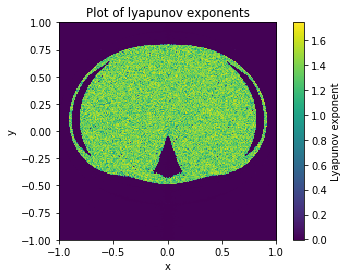

In [135]:
#create lists of x and y ordinates to evalutate est_lyap on
xs = np.linspace(-1, 1, 200)
ys = np.linspace(-1, 1, 200)
xlen = len(xs)
ylen = len(ys)

#create arrays of points to evaluate and their lyapunov exponents
points = []
lyaps = []
#to create a grid of points add a point for each x,y pair
for y in ys:
    for x in xs:
        points.append([[x,y,0]])

for z in points:
    #estimate the lyapunov exponents at this point 
    lyap = est_lyap(z,200, Dt = 5, d0 = 1E-11, solver = 'pw')
    #store result in output list
    lyaps.append(lyap)
#turn output list into array of appropirate size
lyaps = np.array(lyaps)
lyaps = lyaps.reshape(xlen, ylen)
#plot the reult
plt.title('Plot of lyapunov exponents')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(lyaps,extent=[-1,1,-1,1],origin='lower')
cbar = plt.colorbar();
cbar.ax.set_ylabel('Lyapunov exponent')
#save figure in high resolution
plt.savefig("out/lyap.png", dpi = 600)
      

We see here that the system is clearly divided into two regions, a region where the Lyapunov exponent is positive, and one where it is close to zero. The region of positive Lyapunov exponent appears to have a roughly homogenous exponent at this resolution. The region is bounded by an approximately elliptical shape, with the notable exception of two crescent sections and a triangular section at the edges of the region. This supports our hypothesis that points far out from the centre do not exhibit chaotic behaviour as they become better approximated by a single vortex system.  

To understand the behaviour of the system at the three sections inside the chaotic region which do note experience chaos it may be helpful to look at the evolution of the system. Tracers can be placed in the system, coloured according to their initial position, and then the system can be evolved in small time increments, with the position of the tracers periodically plot to form an animation. This is done below

In [40]:
#time increment of how often to caputre a frame
time_increment = 0.01

#coordinates of where to place tracers
xs = np.linspace(-2.3, 2.3, 256)
ys = np.linspace(-1.8, 1.8, 200)

xlen = len(xs)
ylen = len(ys)

xmin = min(xs)
xmax = max(xs)

ymin = min(ys)
ymax = max(ys)

n_tracers = xlen*ylen

#here we define a colour function, the clap function will ensure we always have colour values in the appropirate 0-255 range
clamp = lambda c : 0 if c<0 else (255 if c>255 else c)

#a map which converts x-y coorindates into a RBG channel colour
xmap = lambda x : clamp(int(180*(x - xmin) / (xmax - xmin)+40))
ymap = lambda y : clamp(int(180*(y - ymin) / (ymax - ymin)+40))

#create array for tracer positions and colours
tracers = np.zeros((0,3))
colour = []
for y in ys:
    for x in xs:
        #append colours and initial position of tracers 
        tracers = np.vstack((tracers,np.array([[x,y,0]])))
        colour.append('#%02x%02x%02xB0' % (xmap(-x), xmap(x), ymap(y)))

#simulate for 1000 steps,
for i in range(1000):
    print(i)
    #plot position of tracers
    plt.axis('equal')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.scatter(tracers[:,0],tracers[:,1],color = colour, edgecolor='None', s = 20)
    plt.title('t = ' +str(round(i*time_increment,3)))
    plt.savefig("out/"+str(i)+".png", dpi = 600)
    plt.clf()
    #take time step and update position of each tracer
    for j in range(n_tracers):

        z = [tracers[j]]
        z = solve_blink(z,time_increment, solver = 'pw')[-1:]
        tracers[j] = z[0]
        


0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

From the animation (Mixing Animation.mp4) we can see that the three non-chaotic regions, form a periodic cycle. With the triangular section, shifting to a crescent, then to a triangle on the top half the system, then to another crescent, and finally to its original, with each of these steps taking 0.5 time units. The animation also provides another visual indication of the complex behaviour of the system.

## References

[1] William H. Press and Saul A. Teukolsky. \Adaptive Stepsize Runge-Kutta Integration".
In: Computers in Physics 6.2 (1992), pp. 188{191. doi: 10 . 1063 / 1 . 4823060. eprint:
https://aip.scitation.org/doi/pdf/10.1063/1.4823060. url: https://aip.
scitation.org/doi/abs/10.1063/1.4823060.

[2] H. Aref, "Stirring by chaotic advection," Journal of Fluid Mechanics, vol. 143, pp. 1-21, 2006.